In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import datetime as dt
from utils import (
    calculate_wpv,
    calculate_wpv_uncertainty,
    calculate_bpv,
    calculate_bpv_uncertainty,
    propagate_error_ratio,
)

c:\Users\zita.zarandy\AppData\Local\anaconda3\envs\data\Lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [16]:
ftir_measurements = pd.read_parquet(
    "../data/synthetic_data_1000subjects_5visits_ftir.parquet"
)
columns = [
    float(col) if col[0] in ["1", "2"] else col for col in ftir_measurements.columns
]
ftir_measurements.columns = columns
wavenumbers = columns[:-2]

In [18]:
wpv = calculate_wpv(ftir_measurements, wavenumbers)
bpv = calculate_bpv(ftir_measurements, wavenumbers)
wpv_err = calculate_wpv_uncertainty(ftir_measurements, wavenumbers)
bpv_err = calculate_bpv_uncertainty(ftir_measurements, wavenumbers)
ii, ii_err = propagate_error_ratio(wpv, bpv, wpv_err, bpv_err)

In [20]:
directory_to_save = "outputs"
os.makedirs(directory_to_save, exist_ok=True)

In [21]:
h4h_color = (0 / 255, 125 / 255, 153 / 255)

In [22]:
def plot_split_axis_fixedsize(
    data,
    wavenumbers,
    y_lim,
    color,
    variability,
    label="",
    save_path=None,
    data_std=None,
    title="",
    second_data=None,
    second_std=None,
    second_variability=r"SD$_{A}$",
):

    a, b = 75, 20
    fig = plt.figure(figsize=(10, 3))
    gs = GridSpec(1, 2, width_ratios=[75, 20], wspace=0.13)

    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])

    x = np.array(wavenumbers)
    y = np.array(data)

    ax1.plot(x, y, color="black", linewidth=0.5, label=variability)
    ax2.plot(
        x,
        y,
        color="black",
        linewidth=0.5,
    )

    if data_std is not None:
        lower = y - np.array(data_std)
        upper = y + np.array(data_std)

        ax1.fill_between(
            x,
            lower,
            upper,
            color=color,
            alpha=0.3,
            label=f"uncertainty of {variability}",
        )
        ax2.fill_between(x, lower, upper, color=color, alpha=0.3)

    if second_data is not None:
        ax1.plot(
            x,
            second_data,
            color="black",
            linewidth=0.5,
            linestyle="--",
            label=second_variability,
        )
        ax2.plot(x, second_data, color="black", linewidth=0.5, linestyle="--")

        lower = second_data - second_std
        upper = second_data + second_std

        ax1.fill_between(
            x,
            lower,
            upper,
            color="orange",
            alpha=0.3,
            label=f"uncertainty of {second_variability}",
        )
        ax2.fill_between(x, lower, upper, color="orange", alpha=0.3)

    ax1.set_xlim(1000, 1800)
    ax2.set_xlim(2800, 3000)
    ax1.set_ylim(0, y_lim)
    ax2.set_ylim(0, y_lim)

    ax1.set_xlabel(r"wavenumber (cm$^{-1}$)", fontsize=14)
    ax1.set_ylabel(label, fontsize=20)

    d = 0.015
    kwargs = dict(transform=ax1.transAxes, color="k", clip_on=False)
    ax1.plot((1 - d * (b / a), 1 + d * (b / a)), (-d, +d), linewidth=1, **kwargs)
    ax1.plot((1 - d * (b / a), 1 + d * (b / a)), (1 - d, 1 + d), linewidth=1, **kwargs)

    kwargs.update(transform=ax2.transAxes)
    ax2.plot((-d, d), (-d, +d), linewidth=1, **kwargs)
    ax2.plot((-d, d), (1 - d, 1 + d), linewidth=1, **kwargs)

    ax1.spines["right"].set_visible(False)
    ax2.spines["left"].set_visible(False)
    ax1.yaxis.tick_left()
    ax2.yaxis.tick_right()
    ax2.set_yticklabels([])

    ax1.tick_params(axis="both", labelsize=12)
    ax2.tick_params(axis="both", labelsize=12)

    ax1.yaxis.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
    ax2.yaxis.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

    mean_line = mlines.Line2D([], [], color="black", linewidth=0.5, label="mean")
    if label == "II":
        fill_patch = mpatches.Patch(
            color=color, alpha=0.3, label="mean ± propagated uncertainty"
        )
    else:
        fill_patch = mpatches.Patch(color=color, alpha=0.3, label="mean ± std")
    ax1.legend(fontsize=11, loc="upper center")
    plt.suptitle(title, fontsize=20)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight", pad_inches=0.05)
    plt.show()

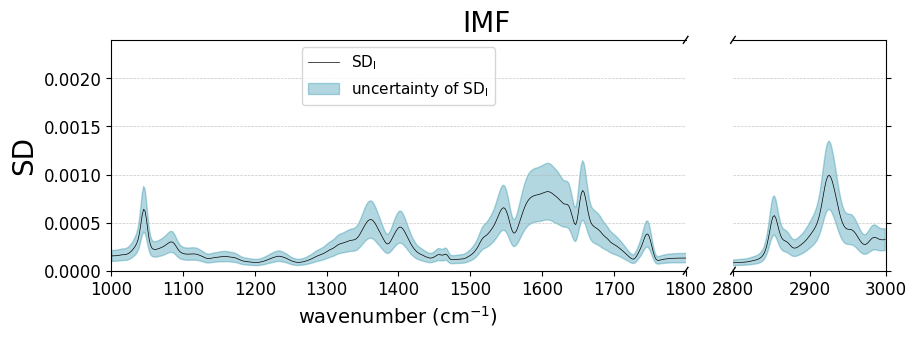

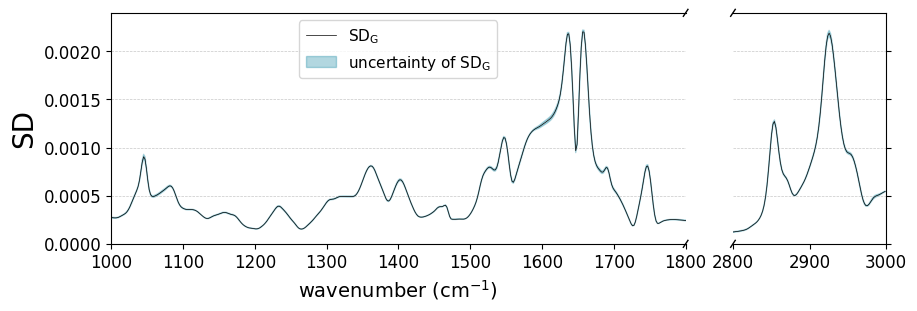

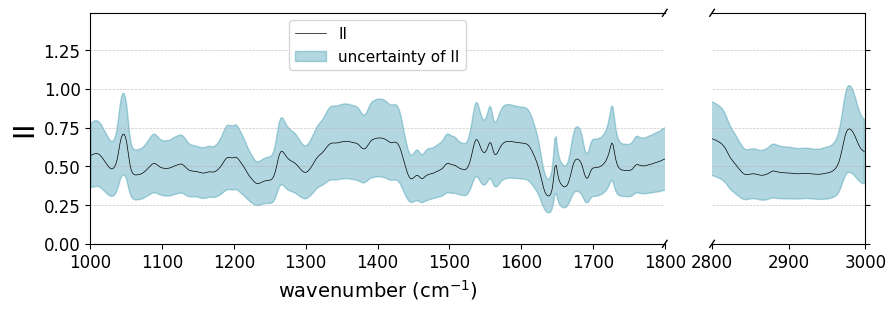

In [23]:
plot_split_axis_fixedsize(
    data=wpv,
    data_std=wpv_err,
    wavenumbers=wavenumbers,
    y_lim=0.0024,
    color=h4h_color,
    label="SD",
    variability=r"SD$_{\mathrm{I}}$",
    title="IMF",
    save_path=directory_to_save + "/wpv_ftir.pdf",
)

plot_split_axis_fixedsize(
    data=bpv,
    data_std=bpv_err,
    wavenumbers=wavenumbers,
    y_lim=0.0024,
    color=h4h_color,
    label="SD",
    variability=r"SD$_{\mathrm{G}}$",
    save_path=directory_to_save + "/bpv_ftir.pdf",
)


plot_split_axis_fixedsize(
    data=ii,
    data_std=ii_err,
    wavenumbers=wavenumbers,
    y_lim=1.49,
    color=h4h_color,
    label="II",
    variability="II",
    save_path=directory_to_save + "/ii_ftir.pdf",
)